In [26]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn.linear_model import LogisticRegression

In [27]:
netflix_titles_1 = pd.read_csv("netflix_titles_1.csv")
netflix_titles_2 = pd.read_csv("netflix_titles_2.csv")
amazon_titles_1 = pd.read_csv("amazon_titles_1.csv")
amazon_titles_2 = pd.read_csv("amazon_titles_2.csv")

In [28]:
#netflix_titles_1.head()
#netflix_titles_2.head()
#amazon_titles_1.head()
#amazon_titles_2.head()

In [29]:
#netflix_titles_1.info()
#netflix_titles_2.info()
#amazon_titles_1.info()
#amazon_titles_2.info()

<h2>1. Integrazione</h1>

Creo due tabelle combinate, una per piattaforma, sull'attributo 'title'.
Non si è osservata alcuna differenza (in quantità di righe risultanti) nel caso in cui il join venisse effettuato sulla chiave ['title', 'release_year'].

In [30]:
# Creazione tabelle combinate 
netflix_titles_combinata = pd.merge(netflix_titles_1,netflix_titles_2[['title', 'date_added', 'country']], on='title', how='left') # join sul titolo perchè gli id sono diversi
#netflix_titles_combinata.info()

amazon_titles_combinata = pd.merge(amazon_titles_1,amazon_titles_2[['title', 'date_added', 'country']], on='title', how='left')
#amazon_titles_combinata.info()

Dal risultato del join sulle tabelle Amazon, mi accorgo che ho veramente poche righe non nulle di 'date_added' e 'country'. Tale risultato è dato dal fatto che originalmente amazon_titles_2 aveva a sua volta pochi valori non nulli corrispondenti a tali colonne.
Dunque mi aspetto già che i prossimi risultati potranno essere influenzati da tale caratteristica.

Procedo dunque nella pulizia dei dati secondo il seguente schema, applicandolo ad entrambe le tabelle combinate delle due piattaforme:


*   Cancello le colonne non utili ai fini richiesti dall'analisi in seguito
*   Cancello i valori nulli presso le colonne di interesse per i test statistici e le predizioni.
<br>
<i>(Localmente a 'imdb_score' e 'tmdb_score' nulli l'alternativa sarebbe stata porre la media dei non nulli; si è scelto comunque di cancellarli in quanto si vuole lasciare il training del metodo predittivo il più pulito possibile (senza influenzarlo con la media; ciò inoltre è stato possibile visto il grande quantitativo di dati nonostante la cancellazione)</i>
<br>
*   Trasformo i valori nulli della 'age_certification' in 'PG', ovvero un generico Parental Guidance Suggested - 'bollino giallo'
*   Infine si osserva che i valori di imdb e tmdb score non presentano rumore del tipo valori fuori range [0,10]





In [31]:
### Pulizia dei dati
## NETFLIX

# netflix_titles_combinata.head()
# Drop colonne: country perchè ha molti null; description, imbd_id, imdb_votes perchè non utili ai nostri fini; seasons perchè contenente molti null
netflix_titles_combinata = netflix_titles_combinata.drop(columns=["country", "description", "imdb_id", "imdb_votes", "seasons"], axis=1)
# Drop righe: cancello le righe nulle su delle feature che mi serviranno in seguito per le predizioni
netflix_titles_combinata = netflix_titles_combinata.dropna(axis=0, subset=['imdb_score', 'tmdb_score', 'tmdb_popularity','runtime', 'production_countries'])

# I valori nulli di age_certification diventeranno un generico PG (Parental Guidance Suggested - 'bollino giallo')
index_null = netflix_titles_combinata["age_certification"].isnull()
netflix_titles_combinata.loc[index_null, 'age_certification'] = 'PG'

# Osservo che non vi è rumore negli score
'''
index_null = netflix_titles_combinata[netflix_titles_combinata["tmdb_score"] > 10]
print(index_null)
index_null = netflix_titles_combinata[netflix_titles_combinata["tmdb_score"] < 0]
print(index_null)
'''

netflix_titles_combinata.reindex()
#netflix_titles_combinata.info()

,id,title,type,release_year,age_certification,runtime,genres,production_countries,imdb_score,tmdb_popularity,tmdb_score,date_added
1,tm82169,Rocky,MOVIE,1976,PG,119,"['romance', 'drama', 'sport']",['US'],8.1,86.593,7.784,"August 1, 2019"
2,tm47802,Psycho,MOVIE,1960,R,109,"['thriller', 'horror', 'drama']",['US'],8.5,31.106,8.446,"May 1, 2020"
3,tm127384,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['comedy', 'fantasy']",['GB'],8.2,22.267,7.804,"January 2, 2019"
4,tm25479,The Birds,MOVIE,1963,PG,113,"['horror', 'drama', 'romance', 'european']",['US'],7.6,22.930,7.519,NaN
5,tm191099,The Sting,MOVIE,1973,PG,129,"['crime', 'drama', 'comedy', 'music']",['US'],8.3,18.007,8.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5988,tm1176905,"From Meir, to Meir",MOVIE,2021,PG,62,['documentation'],['EG'],8.1,1.004,4.000,NaN
5989,tm175364,Chhota Bheem Aur Hanuman,MOVIE,2021,G,67,"['animation', 'fantasy']",['IN'],7.6,0.997,6.200,"July 22, 2021"
5991,tm1094743,Konda Polam,MOVIE,2021,PG,142,"['action', 'drama', 'thriller', 'crime', 'roma...",['IN'],5.7,0.929,6.500,NaN
5993,tm528044,Chhota Bheem Neeli Pahaadi,MOVIE,2021,G,63,['animation'],[],8.8,0.840,10.000,NaN


In [32]:
## AMAZON

# amazon_titles_combinata.head()
# Drop colonne: country perchè ha molti null; description, imbd_id, imdb_votes perchè non utili ai nostri fini; seasons perchè contenente molti null
amazon_titles_combinata = amazon_titles_combinata.drop(columns=["country", "description", "imdb_id", "imdb_votes", "seasons"], axis=1)
# Drop righe: cancello le righe nulle su delle feature che mi serviranno in seguito per le predizioni
amazon_titles_combinata = amazon_titles_combinata.dropna(axis=0, subset=['imdb_score', 'tmdb_score', 'tmdb_popularity', 'runtime', 'production_countries'])

# I valori nulli di age_certification diventeranno un generico PG (Parental Guidance Suggested - 'bollino giallo')
index_null = amazon_titles_combinata["age_certification"].isnull()
amazon_titles_combinata.loc[index_null, 'age_certification'] = 'PG'

amazon_titles_combinata.reindex()
amazon_titles_combinata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8210 entries, 0 to 10701
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    8210 non-null   object 
 1   title                 8210 non-null   object 
 2   type                  8210 non-null   object 
 3   release_year          8210 non-null   int64  
 4   age_certification     8210 non-null   object 
 5   runtime               8210 non-null   int64  
 6   genres                8210 non-null   object 
 7   production_countries  8210 non-null   object 
 8   imdb_score            8210 non-null   float64
 9   tmdb_popularity       8210 non-null   float64
 10  tmdb_score            8210 non-null   float64
 11  date_added            49 non-null     object 
dtypes: float64(3), int64(2), object(7)
memory usage: 833.8+ KB


In [33]:
# Concateno i due dataset combinati
final_titles = pd.concat([netflix_titles_combinata, amazon_titles_combinata])
print('Netflix: ', netflix_titles_combinata.shape)
print('Amazon: ', amazon_titles_combinata.shape)
print('Concatenazione: ',final_titles.shape)

final_titles.head()

Netflix:  (5393, 12)
Amazon:  (8210, 12)
Concatenazione:  (13603, 12)


,id,title,type,release_year,age_certification,runtime,genres,production_countries,imdb_score,tmdb_popularity,tmdb_score,date_added
1,tm82169,Rocky,MOVIE,1976,PG,119,"['romance', 'drama', 'sport']",['US'],8.1,86.593,7.784,"August 1, 2019"
2,tm47802,Psycho,MOVIE,1960,R,109,"['thriller', 'horror', 'drama']",['US'],8.5,31.106,8.446,"May 1, 2020"
3,tm127384,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['comedy', 'fantasy']",['GB'],8.2,22.267,7.804,"January 2, 2019"
4,tm25479,The Birds,MOVIE,1963,PG,113,"['horror', 'drama', 'romance', 'european']",['US'],7.6,22.930,7.519,NaN
5,tm191099,The Sting,MOVIE,1973,PG,129,"['crime', 'drama', 'comedy', 'music']",['US'],8.3,18.007,8.000,NaN


<h1> 2. Trasformazione </h2>

In [34]:
### Sostituzione della colonna date_added con year_added e month_added
netflix_titles_combinata['date_added'] = pd.to_datetime(netflix_titles_combinata['date_added'], errors='coerce') # set null values of date to NaT
netflix_titles_combinata['month_added'] = netflix_titles_combinata['date_added'].dt.month
netflix_titles_combinata['year_added'] = netflix_titles_combinata['date_added'].dt.year
netflix_titles_combinata = netflix_titles_combinata.drop(columns=["date_added"], axis=1)

amazon_titles_combinata['date_added'] = pd.to_datetime(amazon_titles_combinata['date_added'], errors='coerce') # set null values of date to NaT
amazon_titles_combinata['month_added'] = amazon_titles_combinata['date_added'].dt.month
amazon_titles_combinata['year_added'] = amazon_titles_combinata['date_added'].dt.year
amazon_titles_combinata = amazon_titles_combinata.drop(columns=["date_added"], axis=1)

final_titles = pd.concat([netflix_titles_combinata, amazon_titles_combinata])
final_titles.reindex()
final_titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13603 entries, 1 to 10701
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    13603 non-null  object 
 1   title                 13603 non-null  object 
 2   type                  13603 non-null  object 
 3   release_year          13603 non-null  int64  
 4   age_certification     13603 non-null  object 
 5   runtime               13603 non-null  int64  
 6   genres                13603 non-null  object 
 7   production_countries  13603 non-null  object 
 8   imdb_score            13603 non-null  float64
 9   tmdb_popularity       13603 non-null  float64
 10  tmdb_score            13603 non-null  float64
 11  month_added           3306 non-null   float64
 12  year_added            3306 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 1.5+ MB


In [35]:
### Sostituzione della colonna genres con il numero di generi associati genres_number
final_titles.drop(index = 0)
for i in range(len(final_titles)):
    s = str(final_titles["genres"].iloc[i][2:-2])
    news = s.replace("'", "")
    x = news.split(", ")
    final_titles.loc[i,'genres_number'] = len(x);

In [36]:
final_titles.head()

,id,title,type,release_year,age_certification,runtime,genres,production_countries,imdb_score,tmdb_popularity,tmdb_score,month_added,year_added,genres_number
1,tm82169,Rocky,MOVIE,1976.0,PG,119.0,"['romance', 'drama', 'sport']",['US'],8.1,86.593,7.784,8.0,2019.0,3.0
2,tm47802,Psycho,MOVIE,1960.0,R,109.0,"['thriller', 'horror', 'drama']",['US'],8.5,31.106,8.446,5.0,2020.0,2.0
3,tm127384,Monty Python and the Holy Grail,MOVIE,1975.0,PG,91.0,"['comedy', 'fantasy']",['GB'],8.2,22.267,7.804,1.0,2019.0,4.0
4,tm25479,The Birds,MOVIE,1963.0,PG,113.0,"['horror', 'drama', 'romance', 'european']",['US'],7.6,22.930,7.519,NaN,NaN,4.0
5,tm191099,The Sting,MOVIE,1973.0,PG,129.0,"['crime', 'drama', 'comedy', 'music']",['US'],8.3,18.007,8.000,NaN,NaN,2.0


<h1>3. Esplorazione</h1>

Per rappresentare meglio la distribuzione dell'imdb_score in base alle age_certification, si è scelto l'ausilio di un box-plot. Tale grafico permette infatti ad occhio di osservare come oscillano i punteggi in base alla categoria di età, fornendo inoltre un valore mediano.

<Axes: title={'center': 'imdb_score'}, xlabel='age_certification'>

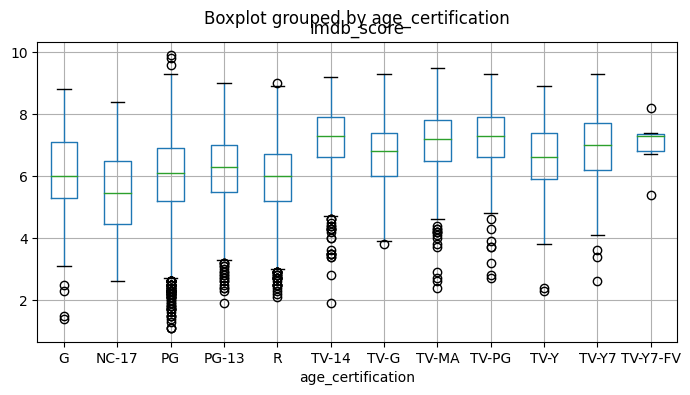

In [37]:
# Rappresentare la distribuzione dell'imdb_score in base alle age_certification
final_titles.boxplot(column='imdb_score', by='age_certification', figsize=(8,4))

Si osserva in particolare un grande numero di outliners, in particolare per PG: tale osservazione denota un punteggio molto basso per film Parental Guidance Suggested. Bisogna dire che la quantità di valori può essere determinata anche dall'azione di pulizia precedentemente citata, che trasforma i valori nulli proprio in PG.

<Axes: >

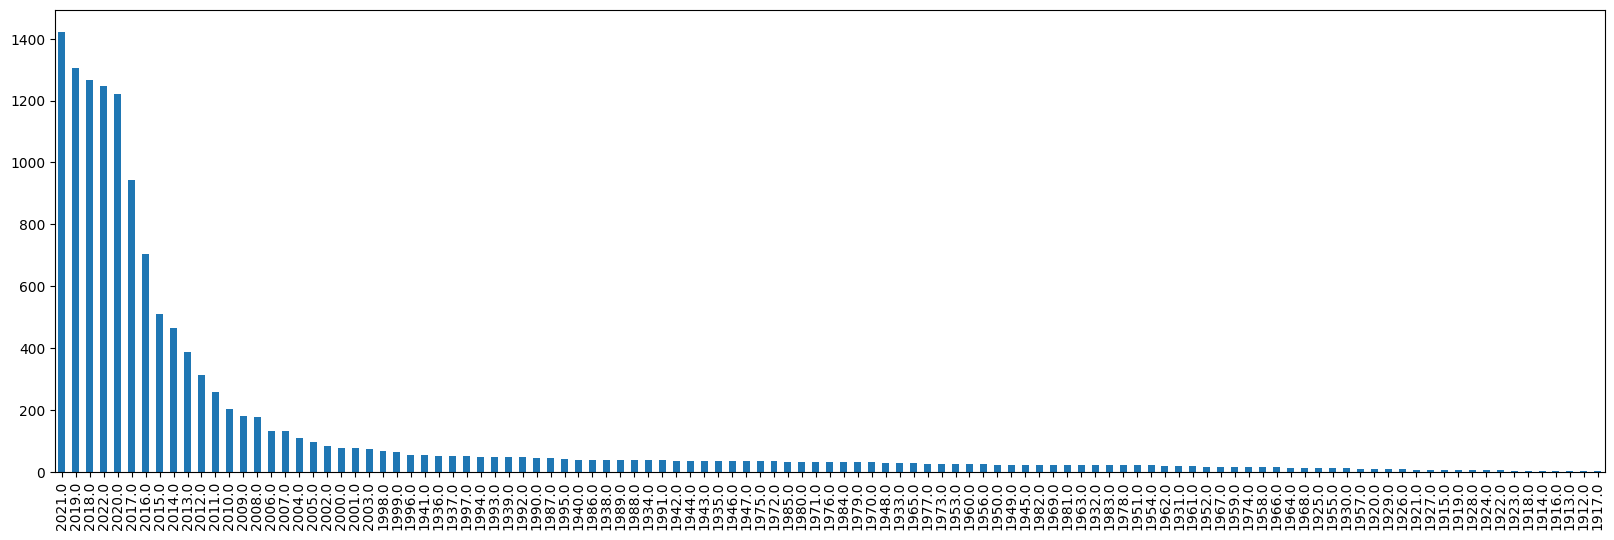

In [38]:
# Rappresentare il numero di programmi prodotti negli anni
# value counts ordina automaticamente dal valore più alto al più basso
production = final_titles['release_year'].value_counts(sort=True)
fig = plt.figure(figsize=(20,6))
production.plot(kind='bar')

# Per verificare
# print(np.sum(final_titles['release_year'] == 2020))

Si può notare dal grafico che la maggior parte dei film presenti in ambo le piattaforme fa riferimento a un periodo annuo che inizia prevalentemente dagli anni 2000. Il picco si raggiunge negli anni fra il 2020 e il 2022.

<Axes: >

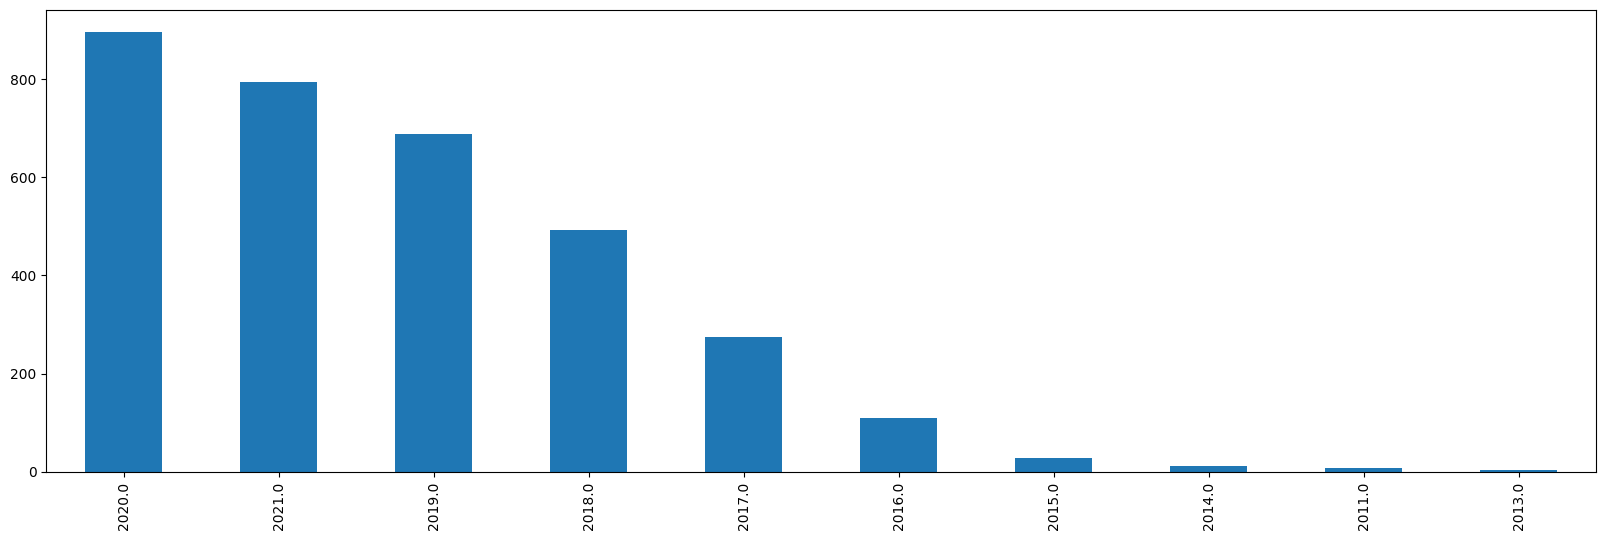

In [39]:
# Rispetto agli anni di caricamento sulle piattaforme
# value counts ordina automaticamente dal valore più alto al più basso
production = final_titles['year_added'].value_counts(sort=True)
fig = plt.figure(figsize=(20,6))
production.plot(kind='bar')

# Per verificare
# print(np.sum(final_titles['year_added'] == 2020))

Similmente a quanto visto per il grafico degli anni di produzione, anche gli anni di caricamento sono prevalentemente gli anni più recenti, dal 2018 al 2021.
Questa ipotesi di somiglianza da luogo a un test statistico che eseguiremo di seguito. 

<h1> 4. Test statistico </h1>

Verifico con un test statistico eventuali differenze nella distribuzione di MOVIE per anno di produzione o per anno di caricamento; piattaforme separate

Scegliamo un livello di significatività di 0.05 (intervallo di confidenza di 0.95).

Ipotesi nulla:

H0 = la distribuzione per anno di rilascio e di caricamento non sono statisticamente diverse

Ipotesi alternativa:

HA = vi è differenza

Vista la necessità di registrare un'eventuale *differenza* fra le distribuzioni, si applica un t-test.
Il test statistico viene effettuato per piattaforma, separando FILM e MOVIE.
Solo in seguito procediamo ad effettuare lo stesso test sulla tabella che combina sia le piattaforme sia il tipo di programma.
Prima di effettuare il test vengono cancellati i valori nulli rispettivamente alle colonne degli anni di produzione e di caricamento. L'alternativa di porre la media dei non nulli presso tali valori non influenza in modo decisivo il t-test.

In [40]:
### NETFLIX
## FILM
# Conto il numero di MOVIE per anno di produzione e anno di caricamento
index_film = netflix_titles_combinata['type'] == 'MOVIE'
netflix_film = netflix_titles_combinata[index_film]

netflix_film = netflix_film.dropna(axis=0, subset=['release_year', 'year_added']) # isolo le righe utili
#netflix_film.info()

### L'alternativa di porre nei nan la media degli anni di caricamento sulla piattaforma non influenza in modo decisivo il t-test
## print(np.mean(netflix_film['year_added']))
## netflix_film['year_added'][np.isnan(netflix_film['year_added'])] = np.mean(netflix_film['year_added'])

# effettuo un t-test
t, p_value = stats.ttest_ind(a = netflix_film['release_year'], b = netflix_film['year_added'])
print('MOVIE')
print('Valore test: ', t)
print('P-value: ', p_value)

# Conto il numero di SHOW per anno di produzione e anno di caricamento
index_series = netflix_titles_combinata['type'] == 'SHOW'
netflix_series = netflix_titles_combinata[index_series]
#netflix_series.info()
netflix_series = netflix_series.dropna(axis=0, subset=['release_year', 'year_added']) # isolo le righe utili

# effettuo un t-test
t, p_value = stats.ttest_ind(a = netflix_series['release_year'], b = netflix_series['year_added'])
print('SHOW')
print('Valore test: ', t)
print('P-value: ', p_value)


MOVIE
Valore test:  -16.625955695815183
P-value:  5.211506302305594e-60
SHOW
Valore test:  -16.32382268740773
P-value:  3.82972499025692e-57


siccome il p-value << significatività, deduciamo che possiamo rigettare l'ipotesi nulla in favore di quella alternativa: non vi sono differenze statisticamente significative fra le due distribuzioni

Per quanto riguarda Amazon si osserva una peculiarità: il numero di campioni non nulli per i MOVIE è pari a 6 < 30 richiesti. Dunque il test statistico non è fattibile.
<br>
D'altra parte gli SHOW rispettano la condizione richiesta ma, come notificato anche da un Warning, i valori sono molto simili (e aggiungerei pochi con pochissima varianza), dunque il t-test porta a una cancellazione catastrofica, con un risultato da considerare non attendibile.
<br>
A valle di ciò, si ritiene dunque il t-test su Amazon non effettuabile in maniera decisiva, data la poca quantità e poca varianza (quindi 'significato') dei dati.

In [56]:
## AMAZON
print('Conteggi righe non nulle per feature')
print(amazon_titles_combinata[amazon_titles_combinata['type'] == 'MOVIE'].count())
# amazon_titles_combinata[amazon_titles_combinata['type'] == 'SHOW'].count()
# NON posso effettuare test statistico per FILM: numero campioni con valori non nulli per year_added sono 6 per amazon. 
# Questo è dato all'origine dall'insieme piccolo di righe non nulle in amazon_titles_2 come puntualizzato nel capitolo "Integrazione".

# Conto il numero di SHOW per anno di produzione e anno di caricamento
index_series = amazon_titles_combinata['type'] == 'SHOW'
amazon_series = amazon_titles_combinata[index_series]

amazon_series = amazon_series.dropna(axis=0, subset=['release_year', 'year_added']) # isolo le righe utili

# effettuo un t-test
t, p_value = stats.ttest_ind(a = amazon_series['release_year'], b = amazon_series['year_added'])
print()
print('Tentativo con SHOW')
print('Valore test: ', t)
print('P-value: ', p_value)

Conteggi righe non nulle per feature
id                      7115
title                   7115
type                    7115
release_year            7115
age_certification       7115
runtime                 7115
genres                  7115
production_countries    7115
imdb_score              7115
tmdb_popularity         7115
tmdb_score              7115
month_added                6
year_added                 6
dtype: int64

Tentativo con SHOW
Valore test:  -5.678064564234941
P-value:  1.9028831007722302e-07


<ipython-input-56-9d0ac08e310c>:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, p_value = stats.ttest_ind(a = amazon_series['release_year'], b = amazon_series['year_added'])


In [42]:
### Test su intero insieme di dati (Amazon + Netflix, Show + Film)

final_titles_test = final_titles.dropna(axis=0, subset=['release_year', 'year_added']) # isolo le righe utili
#final_titles_test.info()

# effettuo un t-test
t, p_value = stats.ttest_ind(a = final_titles_test['release_year'], b = final_titles_test['year_added'])
print('Valore test: ', t)
print('P-value: ', p_value)

# Nuovamente rigettiamo ipotesi nulla a favore di quella alternativa

Valore test:  -22.634540750481538
P-value:  2.59329941535655e-109


Mi accorgo dunque che la supposizione della somiglianza delle distribuzioni non determina un'effettiva uguaglianza statistica, bensì il contrario.

<h1>5. OLAP </h2>

L'OLAP richiesto prende in considerazione i paesi di produzione. Poichè la quantità è notevole, si sceglie di considerare solo i primi 11 più frequenti, ovvero che hanno prodotto più programmi. Per osservarli si grafica un istogramma ordinato.
<br>
Considero invece tutti gli anni di caricamento, in quanto di numero ridotto e pari a 11 anch'esso.

<Axes: >

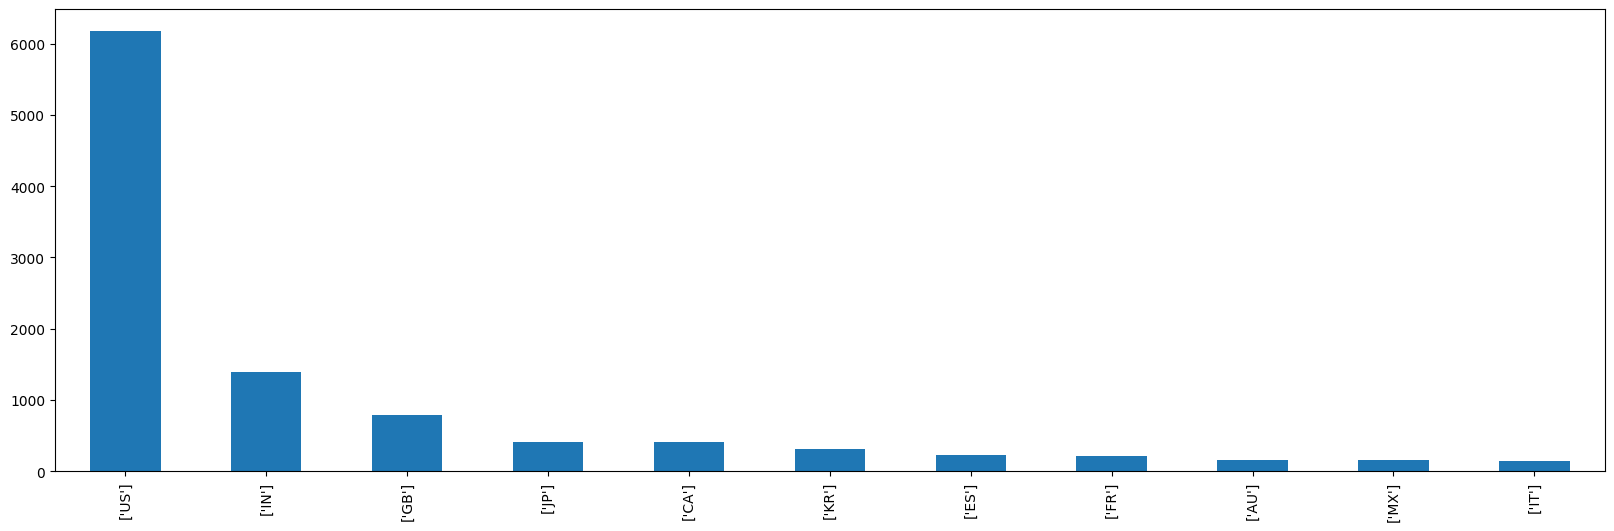

In [43]:
# Plot frequenze
production = final_titles['production_countries'].value_counts(sort=True).take(indices=[0,1,2,3,4,5,6,7,8,9,10])
fig = plt.figure(figsize=(20,6))
production.plot(kind='bar')

In [44]:
quantize_country = ["['US']", "['IN']", "['GB']", "['JP']", "['CA']", "['KR']", "['ES']", "['FR']", "['AU']", "['MX']", "['IT']"] # seleziono i primi 11 stati più frequenti
quantize_year_added = [2009, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021] # qui inserisco tutti gli 11 anni di caricamento
quantize_type = ['MOVIE','SHOW']

OLAP = np.zeros((11,11,2))

for z in range(0,len(quantize_type)): 
  titles_type = final_titles[final_titles['type'] == quantize_type[z]]
  for j in range(0,len(quantize_year_added)):
    for i in range(0,len(quantize_country)):
      OLAP[i,j,z] = np.sum((final_titles['year_added'] == quantize_year_added[j]) & (quantize_country[i] == final_titles['production_countries'])) # ignoro le righe con stati multipli

In [45]:
# Discuto una visualizzazione
# Slicing per MOVIE
print('MOVIE')
OLAP[:,:,0]

MOVIE


array([[  0.,   7.,   3.,   9.,  24.,  59., 131., 175., 233., 301., 265.],
       [  0.,   0.,   0.,   0.,   0.,   2.,  35.,  67.,  75., 107.,  62.],
       [  0.,   0.,   0.,   0.,   0.,   6.,  11.,  25.,  29.,  34.,  33.],
       [  0.,   0.,   0.,   0.,   1.,   4.,  13.,  13.,  22.,  32.,  44.],
       [  0.,   0.,   0.,   0.,   0.,   3.,   7.,  11.,   5.,  16.,  26.],
       [  0.,   0.,   0.,   0.,   0.,   1.,   8.,  15.,  27.,  38.,  39.],
       [  0.,   0.,   0.,   0.,   0.,   1.,   6.,  23.,  27.,  17.,  31.],
       [  0.,   0.,   0.,   0.,   0.,   2.,   2.,  10.,  22.,  18.,  17.],
       [  0.,   0.,   0.,   0.,   0.,   2.,   3.,  10.,   8.,  11.,   4.],
       [  0.,   0.,   0.,   0.,   1.,   1.,   5.,   3.,  14.,  13.,  15.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   2.,   3.,   4.,  11.,   9.]])

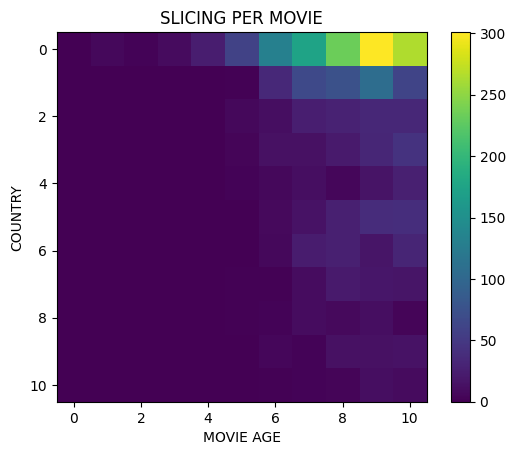

In [46]:
# Visualizzo con heatmap
plt.figure()
plt.imshow(OLAP[:,:,0])
plt.title('SLICING PER MOVIE')
plt.xlabel('MOVIE AGE')
plt.ylabel('COUNTRY')
plt.colorbar()

# Osservo che i film recenti sono stati effettuati maggiormente dagli Stati Uniti nel 2020 (già di per sé anno con maggior numero di film caricato)

Da tale heat-map è possibile notare come la nazione all'indice zero, che corrisponde alla nazione di produzione più frequente, ha prodotto il maggior numero di film corrispondenti ai MOVIE caricati sulla piattaforma nell'anno di indice 9.
<br>
Tutto questo si traduce negli Stati Uniti che hanno prodotto la maggior parte di film caricati sulla piattaforma nell'anno 2020. Tale risultato verifica quanto visto precedentemente negli ultimi due istogrammi: nel primo si osservava l'anno di caricamento maggiore: il 2020; nel secondo la nazione più frequente: gli Stati Uniti. 
<br>
Infine si può notare che la maggior parte delle nazioni, eccetto gli Stati Uniti, non ha prodotto alcun film (presente sulla piattaforma) negli anni dal 2009 al 2015.

<h1> 6. Metodi predittivi </h1>

Prima di applicare il metodo predittivo della regressione logistica, controllo di non avere valori nulli nei descrittori: features = ['imdb_score', 'tmdb_score', 'tmdb_popularity', 'runtime'].

In [53]:
# Controllo di non avere valori nulli nei descrittori: features = ['imdb_score', 'tmdb_score', 'tmdb_popularity', 'runtime']
print('NETFLIX')
netflix_titles_combinata.info()
print()
print()
print('AMAZON')
amazon_titles_combinata.info()

NETFLIX
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5393 entries, 1 to 5994
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5393 non-null   object 
 1   title                 5393 non-null   object 
 2   type                  5393 non-null   object 
 3   release_year          5393 non-null   int64  
 4   age_certification     5393 non-null   object 
 5   runtime               5393 non-null   int64  
 6   genres                5393 non-null   object 
 7   production_countries  5393 non-null   object 
 8   imdb_score            5393 non-null   float64
 9   tmdb_popularity       5393 non-null   float64
 10  tmdb_score            5393 non-null   float64
 11  month_added           3257 non-null   float64
 12  year_added            3257 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 589.9+ KB


AMAZON
<class 'pandas.core.frame.DataFrame'>
Int64Inde

Effettuo il training del mio modello con i dati presi da Netflix

In [48]:
# Training con Netflix
features = ['imdb_score', 'tmdb_score', 'tmdb_popularity', 'runtime']
# netflix_titles_combinata = netflix_titles_combinata.dropna(axis=0, subset=['imdb_score', 'tmdb_score', 'tmdb_popularity', 'runtime']) # questo perchè ho modificato/aggiunto genres_number e production_country

x = netflix_titles_combinata[features]
y = netflix_titles_combinata['type'] # valore di ritorno del modello di predizione

x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(x, y, test_size=0.2, random_state=1)

clf = LogisticRegression()

clf.fit(x_train, y_train) # alleno sui dati di training

print('Training:', clf.score(x_train, y_train))
print('Validation:', clf.score(x_valid, y_valid))

Training: 0.9367176634214186
Validation: 0.9462465245597775


Effettuo il testing con i dati presi da Amazon

In [49]:
# Testing con Amazon
features = ['imdb_score', 'tmdb_score', 'tmdb_popularity', 'runtime']
x = amazon_titles_combinata[features]
y = amazon_titles_combinata['type']

print('Testing:', clf.score(x, y))

Testing: 0.9671132764920828


Creo ora il modello nullo. Per farlo osservo quale classe è prevalente nei miei dati. Dopo aver osservato che tale classe è MOVIE, calcolo la probabilità (percentuale) di ritrovare un MOVIE nell'insieme dei dati di testing (Amazon).

In [50]:
# Il modello nullo ritorna sempre la classe più comune
print(np.sum(amazon_titles_combinata['type'] == 'MOVIE')) # più comune
print(np.sum(amazon_titles_combinata['type'] == 'SHOW'))
print(np.sum(amazon_titles_combinata['type'] == 'MOVIE')/len(amazon_titles_combinata))

7115
1095
0.866626065773447


Osservo che il modello nullo ha accuratezza pari al 87% mentre il modello utilizzato raggiunge il 97%, è dunque un modello applicabile ed efficace.